# A Study on Arrhythmia via ECG Signal Classification Using the Convolutional Neural Network

Yomna Hesham Amin Fekry  *(G19093453)*

Ahmed Mohamed Farouk  *(2000630)*

This is an implementation to the paper **"A Study on Arrhythmia via ECG Signal Classification Using the Convolutional Neural Network"**. 

The author of the paper said that the proposed algorithm is implemented in Matlab, but we cannot find this implementation, so we implemented it in Python


Chuyenmt


# Imports


In [1]:
import numpy as np 
import pandas as pd 
import os

import matplotlib.pyplot as plt
import csv
import itertools
import collections

import pywt
from scipy import stats

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Conv1D, AvgPool1D, Flatten, Dense, Dropout, Softmax
from keras.optimizers import Adam 
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras import regularizers


%matplotlib inline

# matplotlib Settings

In [2]:
plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True 

# Methods Definitions

In [3]:
def denoise(data):  #làm sạch tín hiệu bằng phương pháp làm mờ (denoising) sử dụng Discrete Wavelet Transform (DWT) trong thư viện PyWavelets (pywt).
    w = pywt.Wavelet('sym4') #Xác định sóng (wavelet) được sử dụng là 'sym4'
    maxlev = pywt.dwt_max_level(len(data), w.dec_len) ## Tìm mức độ phân cấp tối đa có thể được áp dụng dựa trên chiều dài của dữ liệu và chiều dài của bộ lọc của sóng.
    threshold = 0.04 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev) ## Áp dụng biến đổi wavelet cho dữ liệu sử dụng sóng 'sym4' và số mức độ phân cấp tối đa tính được
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i])) ## Ngưỡng được áp dụng để loại bỏ nhiễu từ các hệ số của biến đổi wavelet
        
    datarec = pywt.waverec(coeffs, 'sym4')# Tái cấu trúc dữ liệu từ các hệ số đã xử lý để tạo ra tín hiệu đã được làm sạch
    
    return datarec


# Variables Definitions

In [4]:
path = '/kaggle/input/mitbit-arrhythmia-database/mitbih_database/'
window_size = 180
maximum_counting = 10000

classes = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

In [5]:
count_classes

[0, 0, 0, 0, 0]

# Prepere Input Files

In [6]:
# Read files
filenames = next(os.walk(path))[2]#Sử dụng os.walk() để lấy danh sách tất cả các tệp trong thư mục được chỉ định bởi biến path. [2] chỉ trả về danh sách tên các tệp trong thư mục đó.

# Split and save .csv , .txt 
records = list()
annotations = list()
filenames.sort()

In [7]:
filenames

['100.csv',
 '100annotations.txt',
 '101.csv',
 '101annotations.txt',
 '102.csv',
 '102annotations.txt',
 '103.csv',
 '103annotations.txt',
 '104.csv',
 '104annotations.txt',
 '105.csv',
 '105annotations.txt',
 '106.csv',
 '106annotations.txt',
 '107.csv',
 '107annotations.txt',
 '108.csv',
 '108annotations.txt',
 '109.csv',
 '109annotations.txt',
 '111.csv',
 '111annotations.txt',
 '112.csv',
 '112annotations.txt',
 '113.csv',
 '113annotations.txt',
 '114.csv',
 '114annotations.txt',
 '115.csv',
 '115annotations.txt',
 '116.csv',
 '116annotations.txt',
 '117.csv',
 '117annotations.txt',
 '118.csv',
 '118annotations.txt',
 '119.csv',
 '119annotations.txt',
 '121.csv',
 '121annotations.txt',
 '122.csv',
 '122annotations.txt',
 '123.csv',
 '123annotations.txt',
 '124.csv',
 '124annotations.txt',
 '200.csv',
 '200annotations.txt',
 '201.csv',
 '201annotations.txt',
 '202.csv',
 '202annotations.txt',
 '203.csv',
 '203annotations.txt',
 '205.csv',
 '205annotations.txt',
 '207.csv',
 '207ann

In [8]:
# segrefating filenames and annotations
for f in filenames:
    filename, file_extension = os.path.splitext(f) #trích xuất phần mở rộng của tên tệp
    
    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    else:
        annotations.append(path + filename + file_extension)

In [9]:
annotations

['/kaggle/input/mitbit-arrhythmia-database/mitbih_database/100annotations.txt',
 '/kaggle/input/mitbit-arrhythmia-database/mitbih_database/101annotations.txt',
 '/kaggle/input/mitbit-arrhythmia-database/mitbih_database/102annotations.txt',
 '/kaggle/input/mitbit-arrhythmia-database/mitbih_database/103annotations.txt',
 '/kaggle/input/mitbit-arrhythmia-database/mitbih_database/104annotations.txt',
 '/kaggle/input/mitbit-arrhythmia-database/mitbih_database/105annotations.txt',
 '/kaggle/input/mitbit-arrhythmia-database/mitbih_database/106annotations.txt',
 '/kaggle/input/mitbit-arrhythmia-database/mitbih_database/107annotations.txt',
 '/kaggle/input/mitbit-arrhythmia-database/mitbih_database/108annotations.txt',
 '/kaggle/input/mitbit-arrhythmia-database/mitbih_database/109annotations.txt',
 '/kaggle/input/mitbit-arrhythmia-database/mitbih_database/111annotations.txt',
 '/kaggle/input/mitbit-arrhythmia-database/mitbih_database/112annotations.txt',
 '/kaggle/input/mitbit-arrhythmia-databa

In [10]:
records

['/kaggle/input/mitbit-arrhythmia-database/mitbih_database/100.csv',
 '/kaggle/input/mitbit-arrhythmia-database/mitbih_database/101.csv',
 '/kaggle/input/mitbit-arrhythmia-database/mitbih_database/102.csv',
 '/kaggle/input/mitbit-arrhythmia-database/mitbih_database/103.csv',
 '/kaggle/input/mitbit-arrhythmia-database/mitbih_database/104.csv',
 '/kaggle/input/mitbit-arrhythmia-database/mitbih_database/105.csv',
 '/kaggle/input/mitbit-arrhythmia-database/mitbih_database/106.csv',
 '/kaggle/input/mitbit-arrhythmia-database/mitbih_database/107.csv',
 '/kaggle/input/mitbit-arrhythmia-database/mitbih_database/108.csv',
 '/kaggle/input/mitbit-arrhythmia-database/mitbih_database/109.csv',
 '/kaggle/input/mitbit-arrhythmia-database/mitbih_database/111.csv',
 '/kaggle/input/mitbit-arrhythmia-database/mitbih_database/112.csv',
 '/kaggle/input/mitbit-arrhythmia-database/mitbih_database/113.csv',
 '/kaggle/input/mitbit-arrhythmia-database/mitbih_database/114.csv',
 '/kaggle/input/mitbit-arrhythmia-

# Data Extraction and Preprocessing

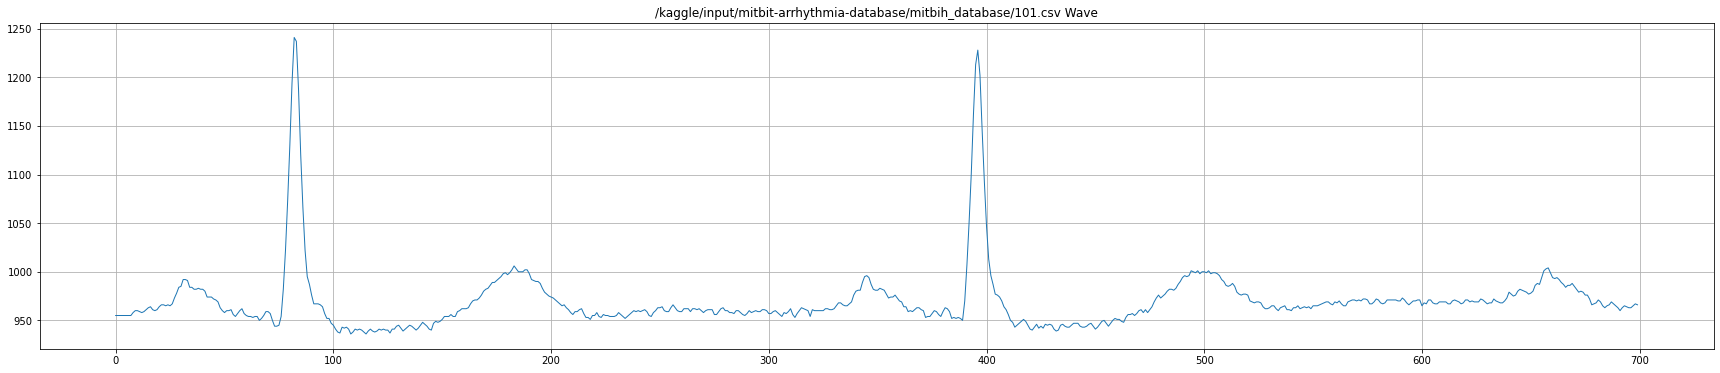

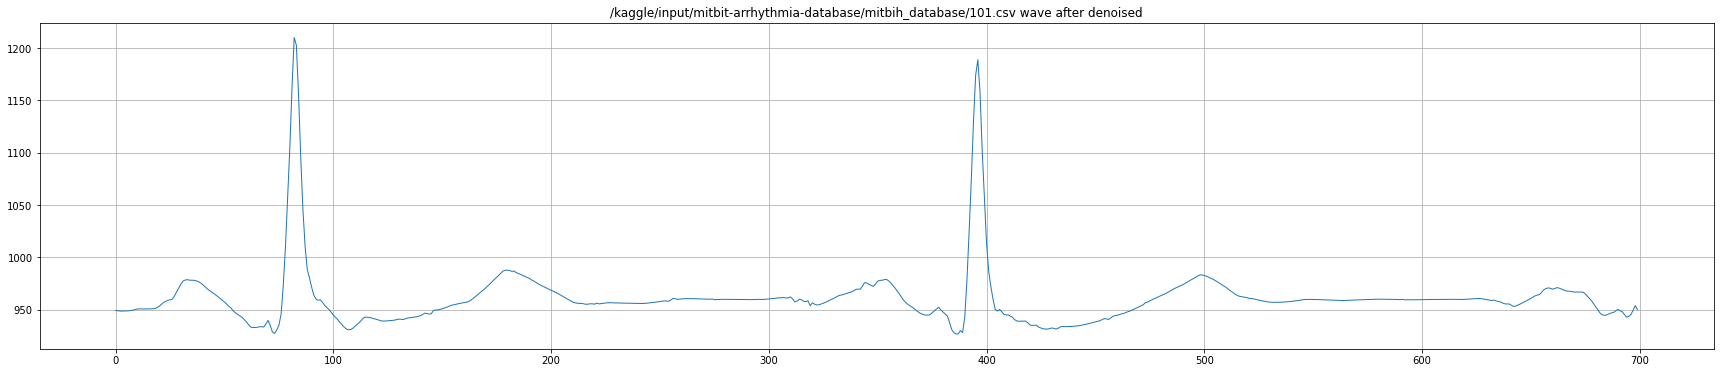

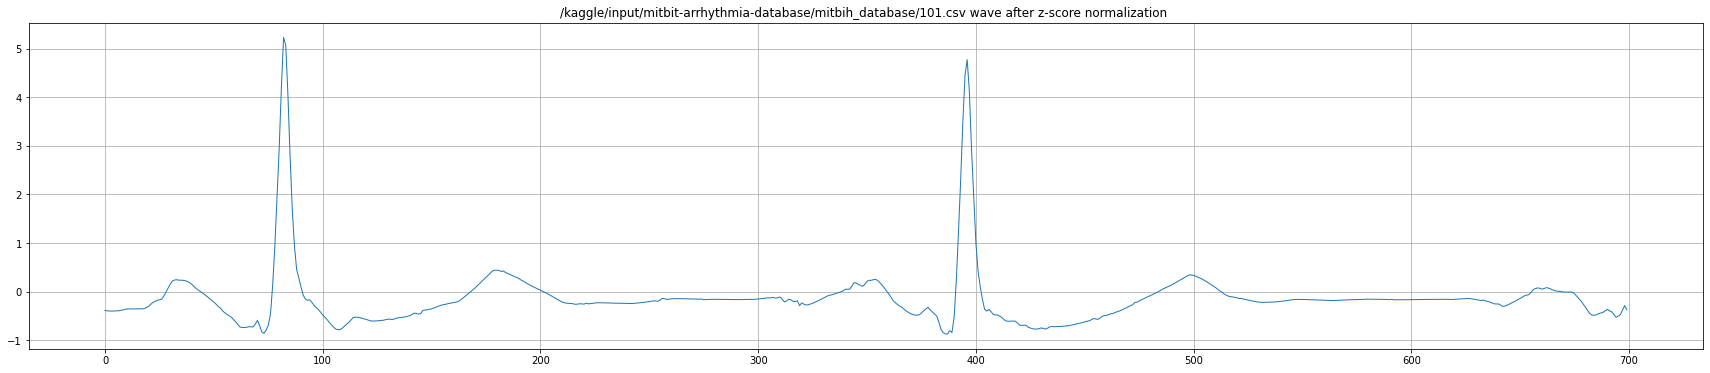

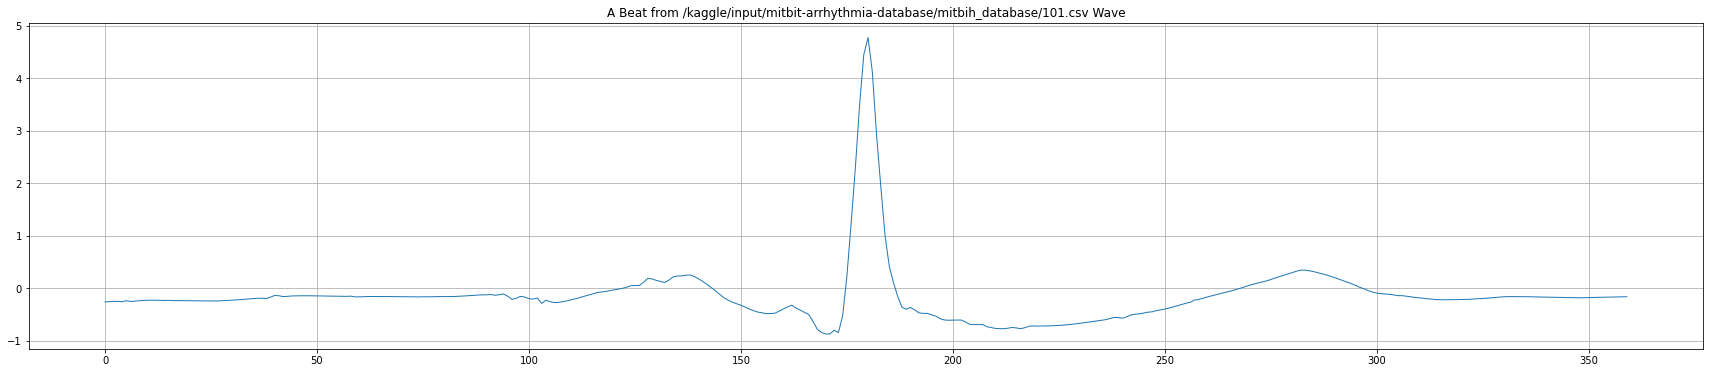

(100012, 360) (100012,)


In [11]:
# Records
for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file\
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1
            
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " Wave")
        plt.plot(signals[0:700])
        plt.show()
        
    signals = denoise(signals)
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " wave after denoised")
        plt.plot(signals[0:700])
        plt.show()
        
    signals = stats.zscore(signals)
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " wave after z-score normalization ")
        plt.plot(signals[0:700])
        plt.show()
    
    # Read anotations: R position and Arrhythmia class
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
#                 if count_classes[arrhythmia_index] > maximum_counting: # avoid overfitting
#                     pass
#                 else:
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]     ## REPLACE WITH R-PEAK DETECTION
                    # Plot an example to a beat    
                    if r is 1 and not example_beat_printed: 
                        plt.title("A Beat from " + records[1] + " Wave")
                        plt.plot(beat)
                        plt.show()
                        example_beat_printed = True

                    X.append(beat)
                    y.append(arrhythmia_index)

# data shape
print(np.shape(X), np.shape(y))


In [12]:
for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i])
#         X[i].append(y[i])

print(np.shape(X))

(100012, 361)


# Classes Distribution

0.0    75011
1.0     8071
2.0     7255
4.0     7129
3.0     2546
Name: 360, dtype: int64


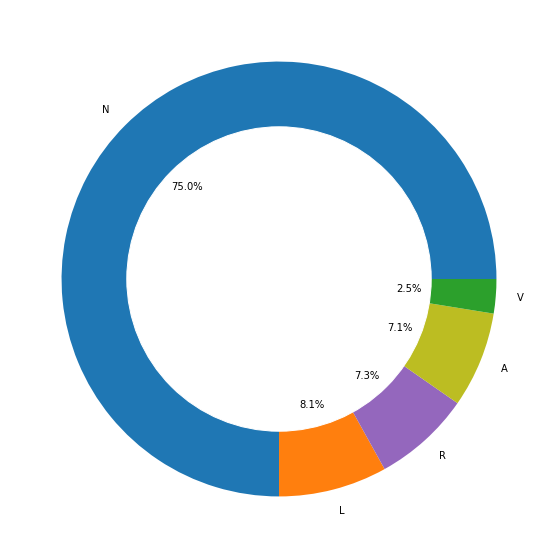

In [13]:
X_train_df = pd.DataFrame(X)
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

# Rebalancing Classes

In [14]:
df_1=X_train_df[X_train_df[X_train_df.shape[1]-1]==1]
df_2=X_train_df[X_train_df[X_train_df.shape[1]-1]==2]
df_3=X_train_df[X_train_df[X_train_df.shape[1]-1]==3]
df_4=X_train_df[X_train_df[X_train_df.shape[1]-1]==4]
# df_5=X_train_df[X_train_df[X_train_df.shape[1]-1]==5]
df_0=(X_train_df[X_train_df[X_train_df.shape[1]-1]==0]).sample(n=5000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=5000,random_state=122)
df_2_upsample=resample(df_2,replace=True,n_samples=5000,random_state=123)
df_3_upsample=resample(df_3,replace=True,n_samples=5000,random_state=124)
df_4_upsample=resample(df_4,replace=True,n_samples=5000,random_state=125)
# df_5_upsample=resample(df_5,replace=True,n_samples=5000,random_state=126)

# X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample,df_5_upsample])
X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

0.0    5000
4.0    5000
2.0    5000
3.0    5000
1.0    5000
Name: 360, dtype: int64


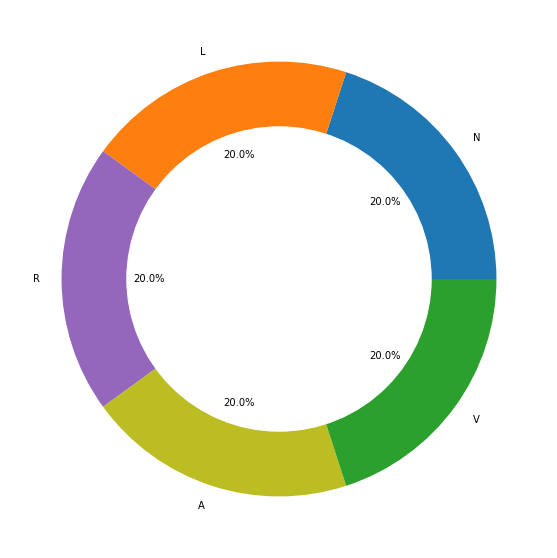

In [15]:
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

# Train-Test Split

In [16]:
train, test = train_test_split(X_train_df, test_size=0.20)

print("X_train : ", np.shape(train))
print("X_test  : ", np.shape(test))

X_train :  (20000, 361)
X_test  :  (5000, 361)


In [17]:
target_train=train[train.shape[1]-1]
target_test=test[test.shape[1]-1]
train_y=to_categorical(target_train)
test_y=to_categorical(target_test)
print(np.shape(train_y), np.shape(test_y))

(20000, 5) (5000, 5)


In [18]:
train_x = train.iloc[:,:train.shape[1]-1].values
test_x = test.iloc[:,:test.shape[1]-1].values
train_x = train_x.reshape(len(train_x), train_x.shape[1],1)
test_x = test_x.reshape(len(test_x), test_x.shape[1],1)
print(np.shape(train_x), np.shape(test_x))

(20000, 360, 1) (5000, 360, 1)


## Building the Model Architecture


In [19]:
# Instanciate an empty model
model = Sequential()

# Adding a Convolution Layer C1
# Input shape = N = (360 x 1)
# No. of filters  = 16
# Filter size = f = (13 x 1)
# Padding = true
# Strides = S = 1
# Size of each feature map in C1 is (N-f+2P)/S +1 = 360-13+2*6 +1 = 360
# No. of parameters between input layer and C1 = (13*1 + 1)*16 = 224
model.add(Conv1D(filters=16, kernel_size=13, padding='same', activation='relu',input_shape=(360, 1)))


# Adding an Average Pooling Layer S2
# Input shape = N = (360 x 16)
# No. of filters = 16
# Filter size = f = (3 x 1)
# Padding = P = 0
# Strides = S = 2
# Size of each feature map in S2 is (N-f+2P+1)/S = (360-3+0+1)/2 = 179
# No. of parameters between C1 and S2 = (1+1)*16 = 32
model.add(AvgPool1D(pool_size=3, strides=2))





# Adding a Convolution Layer C3
# Input shape = N = (179 x 16)
# No. of filters  = 32
# Filter size = f = (15 x 1)
# Padding = true
# Strides = S = 1
# Size of each feature map in C1 is (N-f+2P)/S +1 = 179-15+2*7 +1 = 360
# No. of parameters between input layer and C1 = (15*1 + 1)*32 = 512
model.add(Conv1D(filters=32, kernel_size=15, padding='same', activation='relu'))


# Adding an Average Pooling Layer S4
# Input shape = N = (179 x 32)
# No. of filters = 32
# Filter size = f = (3 x 1)
# Padding = P = 0
# Strides = S = 2
# Size of each feature map in S2 is (N-f+2P+1)/S = (179-3+0+1)/2 = 89
# No. of parameters between C1 and S2 = (1+1)*32 = 64
model.add(AvgPool1D(pool_size=3, strides=2))



# Adding a Convolution Layer C5
# Input shape = N = (89 x 32)
# No. of filters  = 64
# Filter size = f = (17 x 1)
# Padding = true
# Strides = S = 1
# Size of each feature map in C1 is (N-f+2P)/S +1 = 89-17+2*8 +1 = 89
# No. of parameters between input layer and C1 = (17*1 + 1)*64 = 1152
model.add(Conv1D(filters=64, kernel_size=17, padding='same', activation='relu'))



# Adding an Average Pooling Layer S6
# Input shape = N = (89 x 64)
# No. of filters = 64
# Filter size = f = (3 x 1)
# Padding = P = 0
# Strides = S = 2
# Size of each feature map in S2 is (N-f+2P+1)/S = (89-3+0+1)/2 = 44
# No. of parameters between C1 and S2 = (1+1)*64 = 128
model.add(AvgPool1D(pool_size=3, strides=2))



# Adding a Convolution Layer C7
# Input shape = N = (44 x 64)
# No. of filters  = 128
# Filter size = f = (19 x 1)
# Padding = true
# Strides = S = 1
# Size of each feature map in C1 is (N-f+2P)/S +1 = 44-19+2*9 +1 = 44
# No. of parameters between input layer and C1 = (19*1 + 1)*128 = 2560
model.add(Conv1D(filters=128, kernel_size=19, padding='same', activation='relu'))


# Adding an Average Pooling Layer S8
# Input shape = N = (44 x 128)
# No. of filters = 128
# Filter size = f = (3 x 1)
# Padding = P = 0
# Strides = S = 2
# Size of each feature map in S2 is (N-f+2P+1)/S = (44-3+0+1)/2 = 21
# No. of parameters between C1 and S2 = (1+1)*128 = 256
model.add(AvgPool1D(pool_size=3, strides=2))



# Flattening the layer 
# There would be 128*(21*1) = 2688 neurons
model.add(Flatten())


# Dropout the layer S9
model.add(Dropout(0.5))



# Adding a Dense layer with regularization l2(0.0001)# S10
# No. of inputs = 2688
# No. of outputs = 35
# No. of parameters = 2688 x 35 + 35 = 94115
model.add(Dense(35,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))



# Adding a Dense layer with regularization l2(0.0001)# S11
# No. of inputs = 35
# No. of outputs = 5
# No. of parameters = 35*5 + 5 = 180
model.add(Dense(5,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))



# Adding a Softmax layer S12
# No. of inputs = 5
# No. of outputs = 5
model.add(Softmax())


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 360, 16)           224       
_________________________________________________________________
average_pooling1d (AveragePo (None, 179, 16)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 179, 32)           7712      
_________________________________________________________________
average_pooling1d_1 (Average (None, 89, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 89, 64)            34880     
_________________________________________________________________
average_pooling1d_2 (Average (None, 44, 64)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 44, 128)           1

## Compiling the model

In [20]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

## Fitting the model

In [21]:
history = model.fit(train_x, train_y, batch_size=36, epochs=60, verbose=1, validation_data=(test_x, test_y))

Epoch 1/60
556/556 [==============================] - 22s 37ms/step - loss: 0.5936 - accuracy: 0.7844 - val_loss: 0.1561 - val_accuracy: 0.9484
Epoch 2/60
556/556 [==============================] - 20s 37ms/step - loss: 0.1614 - accuracy: 0.9510 - val_loss: 0.1162 - val_accuracy: 0.9614
Epoch 3/60
556/556 [==============================] - 20s 36ms/step - loss: 0.1092 - accuracy: 0.9674 - val_loss: 0.0841 - val_accuracy: 0.9758
Epoch 4/60
556/556 [==============================] - 20s 36ms/step - loss: 0.0924 - accuracy: 0.9732 - val_loss: 0.0952 - val_accuracy: 0.9726
Epoch 5/60
556/556 [==============================] - 21s 37ms/step - loss: 0.0803 - accuracy: 0.9770 - val_loss: 0.0777 - val_accuracy: 0.9798
Epoch 6/60
556/556 [==============================] - 21s 38ms/step - loss: 0.0734 - accuracy: 0.9807 - val_loss: 0.0826 - val_accuracy: 0.9784
Epoch 7/60
556/556 [==============================] - 21s 37ms/step - loss: 0.0702 - accuracy: 0.9825 - val_loss: 0.0633 - val_accuracy:

**Plotting the loss convergence**

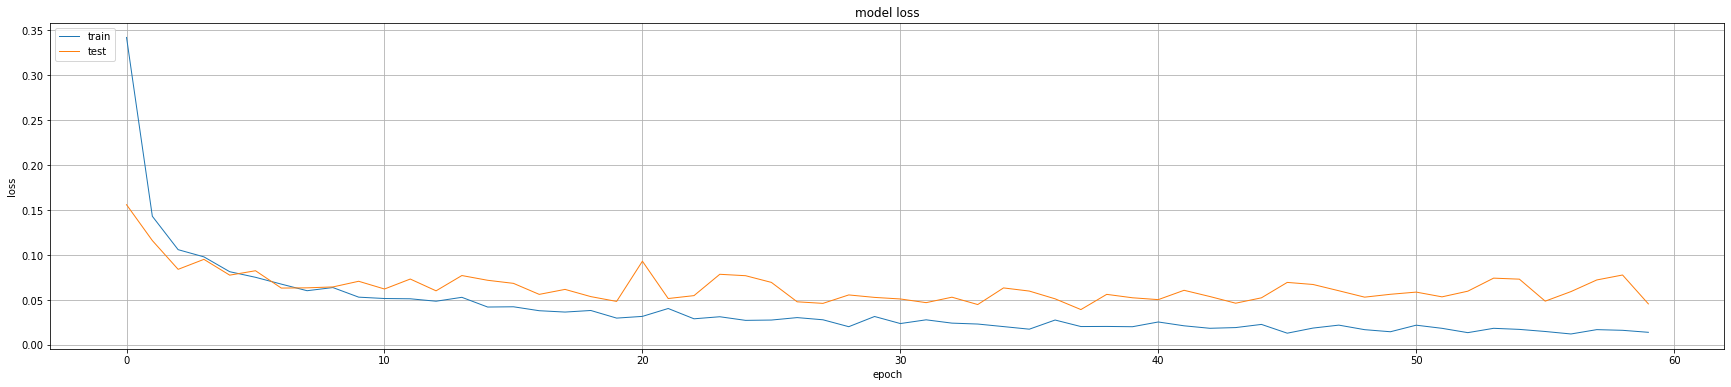

In [22]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Plotting accuracy**

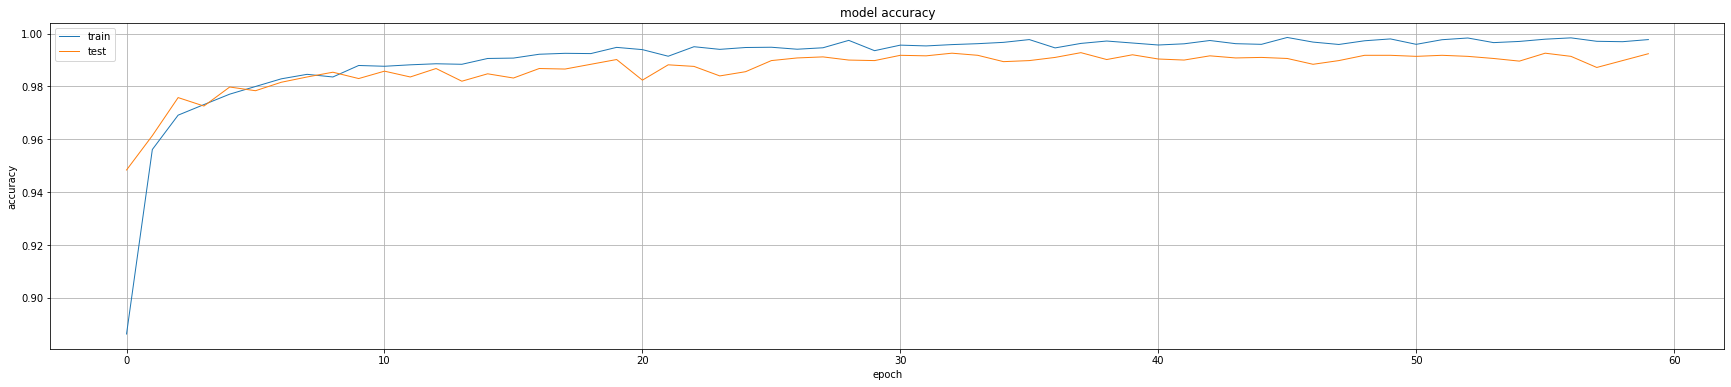

In [23]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Finding the loss and accuracy of the model

In [24]:
score = model.evaluate(test_x, test_y)

print('Test Loss:', score[0])
print('Test accuracy:', score[1])

157/157 [==============================] - 2s 11ms/step - loss: 0.0457 - accuracy: 0.9924
Test Loss: 0.045679911971092224
Test accuracy: 0.9923999905586243


In [25]:
# Lưu trọng số và cấu trúc mô hình vào file
model.save('ten_file_model.h5')


In [26]:
#from tensorflow.keras.models import load_model

# Load lại mô hình từ file
#model = load_model('ten_file_model.h5')
